# Mapping 311 Data in Oakland from 2009
### In this notebook, I want to see what I can find out with the total amount of pothole requests in 2009 as well as the amount of time it took for each request to be closed in each region.

I'll start by importing a bunch of things to get my data organized and making sense.

In [1]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
import urllib.request, json

The files I've downloaded originally had all 311 request data on them, but it was so big that I removed the data that was not from '09 and not related to street deterioration.

In [2]:
oakland09 = gpd.read_file('oakland_data_update.csv')

Time to find our what things look like and what kind of columns I have.

In [3]:
oakland09.head()

REQUESTID      DATETIMEINIT          SOURCE  \
0   323,439   12/8/2009 11:05  Phone or Email   
1   323,234   12/4/2009 16:20  Phone or Email   
2   323,034   12/2/2009 12:51  Phone or Email   
3   323,003   12/2/2009 10:23  Phone or Email   
4   321,683  11/13/2009 12:58  Phone or Email   

                                DESCRIPTION REQCATEGORY          LAT  \
0            Streets - Street Deterioration    STREETSW  37.78827342   
1             Streets - Potholes/Depression    STREETSW  37.82778391   
2  Streets/Sidewalks - Curb & Gutter Repair    STREETSW  37.80638039   
3            Streets - Street Deterioration    STREETSW  37.83726266   
4            Streets - Street Deterioration    STREETSW  37.81606615   

           LONG    STATUS DATETIMECLOSED COUNCILDISTRICT  \
0  -122.1901048  UNFUNDED                           CCD4   
1  -122.1948242    CANCEL                           CCD4   
2  -122.2072523  UNFUNDED                           CCD4   
3  -122.2257336    CLOSED                           CCD1   
4    -122.26249  UNFUNDED                           CCD3   

                PROBADDRESS     City State TIMETOCLOSE geometry  
0            4448 PAMPAS AV  Oakland    CA       40000     None  
1                8 RYDAL CT  Oakland    CA       40000     None  
2          4100 LINCOLN AVE  Oakland    CA       40000     None  
3  HARBORD DR & FLORENCE AV  Oakland    CA       40000     None  
4               275 28TH ST  Oakland    CA       40000     None

In [4]:
oakland09.sample(5)

REQUESTID      DATETIMEINIT          SOURCE  \
226   316,781   9/28/2009 14:03  Phone or Email   
459   322,622  11/24/2009 15:41  Phone or Email   
241   311,122    7/27/2009 9:04  Phone or Email   
28    309,721    7/8/2009 14:29  Phone or Email   
116   319,547  10/22/2009 11:19  Phone or Email   

                        DESCRIPTION REQCATEGORY          LAT          LONG  \
226   Streets - Potholes/Depression    STREETSW  37.79324105  -122.2443262   
459   Streets - Potholes/Depression    STREETSW  37.79792814  -122.2396074   
241   Streets - Potholes/Depression    STREETSW  37.80004922  -122.1983001   
28   Streets - Street Deterioration    STREETSW  37.78733798  -122.1948045   
116   Streets - Potholes/Depression    STREETSW  37.80268728  -122.2205819   

     STATUS    DATETIMECLOSED COUNCILDISTRICT             PROBADDRESS  \
226  CLOSED    1/4/2010 11:26            CCD2     12TH AV & E 18TH ST   
459  CLOSED   12/1/2009 10:46            CCD2     11TH AV & E 24TH ST   
241  CLOSED  10/19/2009 13:41            CCD4       3200 WISCONSIN ST   
28   CLOSED                              CCD4  MACARTHUR BL & HIGH ST   
116  CLOSED   5/11/2010 11:44            CCD5  E 38TH ST & LINWOOD AV   

        City State TIMETOCLOSE geometry  
226  Oakland    CA        97.9     None  
459  Oakland    CA         6.8     None  
241  Oakland    CA        84.2     None  
28   Oakland    CA       40000     None  
116  Oakland    CA         201     None

I need to find out more info about this dataset, so I will use the relevant command. Because it's all from a csv file, I figure certain columns will not be the right type of data to plot geographically.

In [5]:
oakland09.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   REQUESTID        526 non-null    object  
 1   DATETIMEINIT     526 non-null    object  
 2   SOURCE           526 non-null    object  
 3   DESCRIPTION      526 non-null    object  
 4   REQCATEGORY      526 non-null    object  
 5   LAT              526 non-null    object  
 6   LONG             526 non-null    object  
 7   STATUS           526 non-null    object  
 8   DATETIMECLOSED   526 non-null    object  
 9   COUNCILDISTRICT  526 non-null    object  
 10  PROBADDRESS      526 non-null    object  
 11  City             526 non-null    object  
 12  State            526 non-null    object  
 13  TIMETOCLOSE      526 non-null    object  
 14  geometry         0 non-null      geometry
dtypes: geometry(1), object(14)
memory usage: 61.8+ KB


In [6]:
latitude = oakland09['LAT']

In [7]:
latitude.head()

0    37.78827342
1    37.82778391
2    37.80638039
3    37.83726266
4    37.81606615
Name: LAT, dtype: object

In [8]:
longitude = oakland09['LONG']

In [9]:
longitude.tail()

521    -122.2534458
522     -122.205585
523    -122.2332864
524    -122.2648865
525    -122.2548987
Name: LONG, dtype: object

Wait, I actually did not do that right at all, so let me try again to actually change the dtype of the latitude and longitude columns

In [10]:
oakland09['LAT'] = oakland09['LAT'].astype(float)

In [11]:
oakland09['LONG'] = oakland09['LONG'].astype(float)

In [12]:
oakland09.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   REQUESTID        526 non-null    object  
 1   DATETIMEINIT     526 non-null    object  
 2   SOURCE           526 non-null    object  
 3   DESCRIPTION      526 non-null    object  
 4   REQCATEGORY      526 non-null    object  
 5   LAT              526 non-null    float64 
 6   LONG             526 non-null    float64 
 7   STATUS           526 non-null    object  
 8   DATETIMECLOSED   526 non-null    object  
 9   COUNCILDISTRICT  526 non-null    object  
 10  PROBADDRESS      526 non-null    object  
 11  City             526 non-null    object  
 12  State            526 non-null    object  
 13  TIMETOCLOSE      526 non-null    object  
 14  geometry         0 non-null      geometry
dtypes: float64(2), geometry(1), object(12)
memory usage: 61.8+ KB


Yippee, okay so that did work. I wonder if I should just look at a list of all the columns in case I want to change anything

In [13]:
oakland09.columns.to_list()

['REQUESTID',
 'DATETIMEINIT',
 'SOURCE',
 'DESCRIPTION',
 'REQCATEGORY',
 'LAT',
 'LONG',
 'STATUS',
 'DATETIMECLOSED',
 'COUNCILDISTRICT',
 'PROBADDRESS',
 'City',
 'State',
 'TIMETOCLOSE',
 'geometry']

Nah, I'll leave it for now. Now I'll try to actually plot the requests. These requests include all about street deterioration in 2009, including the requests that were canceled or never resolved.

In [14]:
oakland09 = gpd.GeoDataFrame(oakland09,
                             crs='epsg:4326',
                             geometry=gpd.points_from_xy(oakland09.LONG, oakland09.LAT))

<AxesSubplot:>

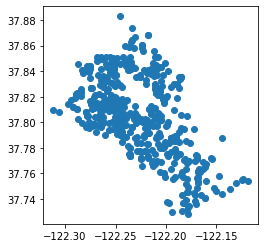

In [15]:
oakland09.plot()

It's not too overwhelming, because it is 2009 and comparing the requests to 2019, I only have 526 compared to Nick's several thousand. Now I want to look at the time-to-close data. In Excel, I wanted to really set the data apart if it was left open, so I added data saying that an open ticket took 40,000 days to resolve. I did this because there were one or two tickets that were closed in 0 days, and I didn't want the tickets that were left open to skew that.

In [16]:
oakland09['TIMETOCLOSE']

0      40000
1      40000
2      40000
3      40000
4      40000
       ...  
521      0.1
522      0.1
523        0
524        0
525        0
Name: TIMETOCLOSE, Length: 526, dtype: object

In [17]:
oakland09['TIMETOCLOSE'] == '40000', True

(0       True
 1       True
 2       True
 3       True
 4       True
        ...  
 521    False
 522    False
 523    False
 524    False
 525    False
 Name: TIMETOCLOSE, Length: 526, dtype: bool,
 True)

In [18]:
timetoclose = oakland09['TIMETOCLOSE']

In [19]:
timetoclose.sample()

467    5.9
Name: TIMETOCLOSE, dtype: object

Realizing that I would rather have the time to close as a float or integer, but I don't think it will let me change it to an integer because there are a good amount of decimals in the data, just looking at the charts.

In [20]:
timetoclose = oakland09['TIMETOCLOSE'].astype(float)

In [21]:
timetoclose.mean()

3033.4663498098876

The mean here is for sure skewed because of all the 40k day closure times I put in for the open tickets. I want to see how many of those open tickets I have.

In [22]:
oakland09['TIMETOCLOSE'].value_counts()

40000    38
4         6
14        6
4.3       5
5.8       5
         ..
136.1     1
137.1     1
139.9     1
645.8     1
84.1      1
Name: TIMETOCLOSE, Length: 366, dtype: int64

In [23]:
timetoclose != '40000'

0      True
1      True
2      True
3      True
4      True
       ... 
521    True
522    True
523    True
524    True
525    True
Name: TIMETOCLOSE, Length: 526, dtype: bool

Now I might as well just get a full list of those opened tickets, since there are only 38 of them.

In [24]:
oakland09[oakland09.TIMETOCLOSE == '40000']

REQUESTID      DATETIMEINIT          SOURCE  \
0    323,439   12/8/2009 11:05  Phone or Email   
1    323,234   12/4/2009 16:20  Phone or Email   
2    323,034   12/2/2009 12:51  Phone or Email   
3    323,003   12/2/2009 10:23  Phone or Email   
4    321,683  11/13/2009 12:58  Phone or Email   
5    320,488   11/2/2009 14:56  Phone or Email   
6    320,012  10/28/2009 16:18  Phone or Email   
7    319,523   10/22/2009 9:48  Phone or Email   
8    319,414  10/21/2009 11:41  Phone or Email   
9    318,961   10/19/2009 8:47  Phone or Email   
10   318,791  10/15/2009 16:03  Phone or Email   
11   318,181  10/12/2009 16:27  Phone or Email   
12   318,076   10/12/2009 9:46  Phone or Email   
13   317,310   10/2/2009 15:10  Phone or Email   
14   317,268   10/2/2009 11:19  Phone or Email   
15   315,903   9/17/2009 15:38  Phone or Email   
16   315,352   9/14/2009 10:21  Phone or Email   
17   313,717   8/25/2009 10:38  Phone or Email   
18   312,589   8/12/2009 14:35  Phone or Email   
19   312,442   8/11/2009 14:13  Phone or Email   
20   312,395   8/11/2009 10:11  Phone or Email   
21   312,385    8/11/2009 9:09  Phone or Email   
22   312,376    8/11/2009 8:38  Phone or Email   
23   310,547   7/17/2009 16:20  Phone or Email   
24   310,465    7/17/2009 9:47  Phone or Email   
25   310,006   7/10/2009 16:31  Phone or Email   
26   309,967   7/10/2009 14:53  Phone or Email   
27   309,844    7/9/2009 14:02  Phone or Email   
28   309,721    7/8/2009 14:29  Phone or Email   
29   309,178     7/2/2009 9:18  Phone or Email   
30   309,645     7/8/2009 9:34  Phone or Email   
31   315,380   9/14/2009 11:52  Phone or Email   
32   317,279   10/2/2009 12:20  Phone or Email   
33   315,876   9/17/2009 15:03  Phone or Email   
34   320,709    11/4/2009 9:02  Phone or Email   
35   320,530   11/2/2009 15:45  Phone or Email   
36   322,783    12/1/2009 9:55  Phone or Email   
37   312,373    8/11/2009 8:24  Phone or Email   

                                 DESCRIPTION REQCATEGORY        LAT  \
0             Streets - Street Deterioration    STREETSW  37.788273   
1              Streets - Potholes/Depression    STREETSW  37.827784   
2   Streets/Sidewalks - Curb & Gutter Repair    STREETSW  37.806380   
3             Streets - Street Deterioration    STREETSW  37.837263   
4             Streets - Street Deterioration    STREETSW  37.816066   
5              Streets - Potholes/Depression    STREETSW  37.808126   
6             Streets - Street Deterioration    STREETSW  37.807092   
7             Streets - Street Deterioration    STREETSW  37.813778   
8    Streets/Sidewalks Maintenance - General    STREETSW  37.779806   
9    Streets/Sidewalks Maintenance - General    STREETSW  37.827143   
10            Streets - Street Deterioration    STREETSW  37.847115   
11   Streets/Sidewalks Maintenance - General    STREETSW  37.845879   
12            Streets - Street Deterioration    STREETSW  37.819132   
13   Streets/Sidewalks Maintenance - General    STREETSW  37.838308   
14  Streets/Sidewalks - Curb & Gutter Repair    STREETSW  37.788986   
15               Streets - Speed Bump Repair    STREETSW  37.816453   
16            Streets - Street Deterioration    STREETSW  37.801129   
17   Streets/Sidewalks Maintenance - General    STREETSW  37.841564   
18            Streets - Street Deterioration    STREETSW  37.818224   
19            Streets - Street Deterioration    STREETSW  37.779866   
20             Streets - Potholes/Depression    STREETSW  37.822838   
21             Streets - Potholes/Depression    STREETSW  37.780069   
22            Streets - Street Deterioration    STREETSW  37.808964   
23            Streets - Street Deterioration    STREETSW  37.844586   
24   Streets/Sidewalks Maintenance - General    STREETSW  37.817204   
25            Streets - Street Deterioration    STREETSW  37.830148   
26            Streets - Street Deterioration    STREETSW  37.812911   
27            Streets - Street Deterioration    STREETSW  37.830

Just for fun, I might as well plot out the open vs. closed tickets and separate the main data into open & closed versions.

In [25]:
oakland09_open = oakland09[oakland09.TIMETOCLOSE == '40000']

<AxesSubplot:>

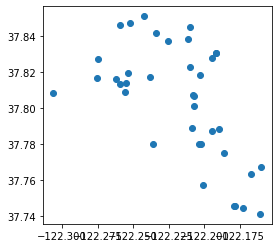

In [26]:
oakland09_open.plot()

In [27]:
oakland09_closed= oakland09[oakland09.TIMETOCLOSE != '40000']

<AxesSubplot:>

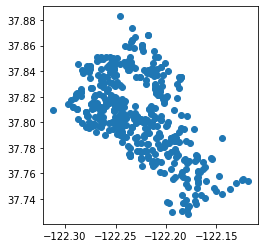

In [28]:
oakland09_closed.plot()

Since I'm probably going to leave behind the open tickets, I'm just going to take another look at the closed/completed tickets and use those for the actual maps. Just based on the quick plot from a couple cells ago, it doesn't look like the opened tickets are distributed heavily in one area, so I doubt that there's anything sinister behind the unclosed tickets.

In [29]:
oakland09_closed.head()

REQUESTID      DATETIMEINIT          SOURCE  \
38   312,392    8/11/2009 9:47  Phone or Email   
39   310,597   7/20/2009 14:30  Phone or Email   
40   313,730   8/25/2009 11:40  Phone or Email   
41   321,710  11/13/2009 14:59  Phone or Email   
42   320,858    11/5/2009 9:14  Phone or Email   

                                DESCRIPTION REQCATEGORY        LAT  \
38           Streets - Street Deterioration    STREETSW  37.769205   
39           Streets - Street Deterioration    STREETSW  37.760284   
40  Streets/Sidewalks Maintenance - General    STREETSW  37.772975   
41           Streets - Street Deterioration    STREETSW  37.770417   
42           Streets - Street Deterioration    STREETSW  37.737952   

          LONG  STATUS   DATETIMECLOSED COUNCILDISTRICT  \
38 -122.204626  CLOSED  6/23/2016 19:04            CCD6   
39 -122.202325  CLOSED    8/7/2015 9:53            CCD6   
40 -122.189995  CLOSED  7/21/2015 10:54            CCD6   
41 -122.181830  CLOSED  7/21/2015 16:33            CCD6   
42 -122.171227  CLOSED  5/14/2014 17:14            CCD7   

                         PROBADDRESS     City State TIMETOCLOSE  \
38                      1521 54TH AV  Oakland    CA      2508.4   
39                     1100 62ND AVE  Oakland    CA      2208.8   
40                   5807 FLEMING AV  Oakland    CA        2156   
41  FOOTHILL BLVD & HAVENSCOURT BLVD  Oakland    CA      2076.1   
42           104TH AV & ROYAL ANN ST  Oakland    CA      1651.3   

                       geometry  
38  POINT (-122.20463 37.76920)  
39  POINT (-122.20232 37.76028)  
40  POINT (-122.19000 37.77298)  
41  POINT (-122.18183 37.77042)  
42  POINT (-122.17123 37.73795)

In [30]:
oakland09_closed.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 488 entries, 38 to 525
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   REQUESTID        488 non-null    object  
 1   DATETIMEINIT     488 non-null    object  
 2   SOURCE           488 non-null    object  
 3   DESCRIPTION      488 non-null    object  
 4   REQCATEGORY      488 non-null    object  
 5   LAT              488 non-null    float64 
 6   LONG             488 non-null    float64 
 7   STATUS           488 non-null    object  
 8   DATETIMECLOSED   488 non-null    object  
 9   COUNCILDISTRICT  488 non-null    object  
 10  PROBADDRESS      488 non-null    object  
 11  City             488 non-null    object  
 12  State            488 non-null    object  
 13  TIMETOCLOSE      488 non-null    object  
 14  geometry         488 non-null    geometry
dtypes: float64(2), geometry(1), object(12)
memory usage: 61.0+ KB


In [31]:
timetoclose.sample()

312    33.7
Name: TIMETOCLOSE, dtype: float64

I made a time to close variable earlier, so I can see what it looks like on a graph.

<AxesSubplot:>

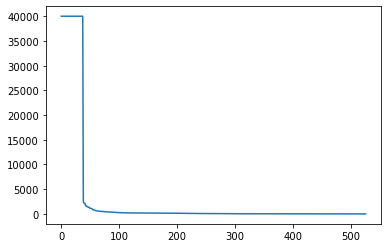

In [32]:
timetoclose.plot()

Oops, forgot that my timetoclose variable included a bunch of requests that were never closed. I'll do that plotting later, because I want to make sure that my data for the closed requests is all set.

In [33]:
oakland09_closed['TIMETOCLOSE'] = oakland09_closed['TIMETOCLOSE'].astype(float)

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [34]:
oakland09_closed.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 488 entries, 38 to 525
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   REQUESTID        488 non-null    object  
 1   DATETIMEINIT     488 non-null    object  
 2   SOURCE           488 non-null    object  
 3   DESCRIPTION      488 non-null    object  
 4   REQCATEGORY      488 non-null    object  
 5   LAT              488 non-null    float64 
 6   LONG             488 non-null    float64 
 7   STATUS           488 non-null    object  
 8   DATETIMECLOSED   488 non-null    object  
 9   COUNCILDISTRICT  488 non-null    object  
 10  PROBADDRESS      488 non-null    object  
 11  City             488 non-null    object  
 12  State            488 non-null    object  
 13  TIMETOCLOSE      488 non-null    float64 
 14  geometry         488 non-null    geometry
dtypes: float64(3), geometry(1), object(11)
memory usage: 61.0+ KB


In [35]:
oakland09_closed['TIMETOCLOSE'].value_counts()

14.0     6
4.0      6
4.3      5
5.8      5
14.9     4
        ..
152.2    1
152.7    1
152.9    1
153.0    1
84.1     1
Name: TIMETOCLOSE, Length: 365, dtype: int64

Might as well see what this data looks like, and what council districts have the most requests. I don't know much about Oakland, and also I couldn't find out if council district borders have changed since '09, so this is mostly just for fun.

In [36]:
oakland09_closed['COUNCILDISTRICT'].value_counts()

CCD1        104
CCD4         96
CCD2         88
CCD3         69
CCD5         54
CCD7         40
CCD6         32
Piedmont      3
              2
Name: COUNCILDISTRICT, dtype: int64

Hmm ok... Piedmont isn't in Oakland at all but it's only 3 rows so maybe I should just leave it? Now I want to see what the time data looks like in a chart.

<AxesSubplot:ylabel='Frequency'>

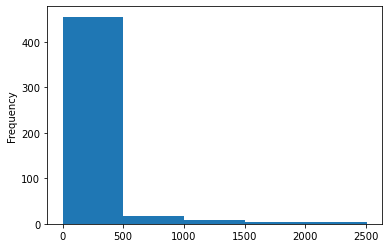

In [37]:
oakland09_closed['TIMETOCLOSE'].plot.hist(bins=5)

Most 311 tickets are closed in well under 500 days

In [38]:
oakland09_closed['SOURCE'].value_counts()

Phone or Email    488
Name: SOURCE, dtype: int64

All 311 requests from 2009 made by phone or email

In [39]:
timetoclose = oakland09_closed['TIMETOCLOSE']

<AxesSubplot:>

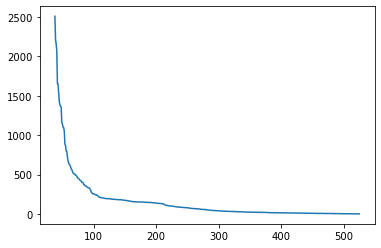

In [40]:
timetoclose.plot()

Ok, this makes more sense than when I still had the massive outliers in my timetoclose variable.

## Overlaying Requests with Census Blocks

Now I am going to import some more data and merge it so that I can see how the request data looks when it's actually placed within block group borders. I am bringing in census block group geography from Oakland's open data page.

In [43]:
blocks = gpd.read_file('Data/Alameda_Census_Blocks_2010.geojson')

In [44]:
blocks.head()

statefp10 mtfcc10 uace10      name10   intptlat10 blockce10 awater10  \
0        06   G5040         Block 2024  +37.7514499      2024        0   
1        06   G5040         Block 2017  +37.7700438      2017        0   
2        06   G5040         Block 2011  +37.7945823      2011        0   
3        06   G5040         Block 2002  +37.8343484      2002        0   
4        06   G5040         Block 1005  +37.7783082      1005        0   

  funcstat10 aland10          geoid10 tractce10    intptlon10 ur10 countyfp10  \
0          S    1180  060014100002024    410000  -122.1244488             001   
1          S     553  060014073002017    407300  -122.2099801             001   
2          S   11797  060014081002011    408100  -122.1820803             001   
3          S     598  060014010002002    401000  -122.2699940             001   
4          S     139  060014061001005    406100  -122.2273093             001   

                                            geometry  
0  MULTIPOLYGON (((-122.12489 37.75164, -122.1247...  
1  MULTIPOLYGON (((-122.21025 37.77010, -122.2101...  
2  MULTIPOLYGON (((-122.18212 37.79493, -122.1818...  
3  MULTIPOLYGON (((-122.27004 37.83399, -122.2701...  
4  MULTIPOLYGON (((-122.22720 37.77830, -122.2272...

<AxesSubplot:>

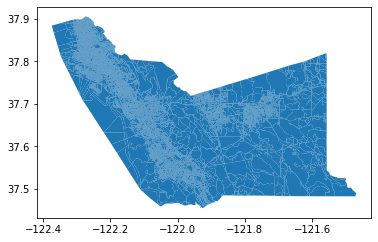

In [45]:
blocks.plot()

Ok, looks like Oakland. Now I will join the different sets of data and see what that leaves me with.

In [46]:
joined = gpd.sjoin(oakland09_closed, blocks, how='left')

In [47]:
joined.head()

REQUESTID      DATETIMEINIT          SOURCE  \
38   312,392    8/11/2009 9:47  Phone or Email   
39   310,597   7/20/2009 14:30  Phone or Email   
40   313,730   8/25/2009 11:40  Phone or Email   
41   321,710  11/13/2009 14:59  Phone or Email   
42   320,858    11/5/2009 9:14  Phone or Email   

                                DESCRIPTION REQCATEGORY        LAT  \
38           Streets - Street Deterioration    STREETSW  37.769205   
39           Streets - Street Deterioration    STREETSW  37.760284   
40  Streets/Sidewalks Maintenance - General    STREETSW  37.772975   
41           Streets - Street Deterioration    STREETSW  37.770417   
42           Streets - Street Deterioration    STREETSW  37.737952   

          LONG  STATUS   DATETIMECLOSED COUNCILDISTRICT  ...   intptlat10  \
38 -122.204626  CLOSED  6/23/2016 19:04            CCD6  ...  +37.7700052   
39 -122.202325  CLOSED    8/7/2015 9:53            CCD6  ...  +37.7593981   
40 -122.189995  CLOSED  7/21/2015 10:54            CCD6  ...  +37.7736084   
41 -122.181830  CLOSED  7/21/2015 16:33            CCD6  ...  +37.7702147   
42 -122.171227  CLOSED  5/14/2014 17:14            CCD7  ...  +37.7372270   

   blockce10 awater10  funcstat10 aland10          geoid10 tractce10  \
38      1011        0           S   49663  060014074001011    407400   
39      4014        0           S  154949  060014088004014    408800   
40      1026        0           S   23040  060014077001026    407700   
41      2003        0           S   26358  060014087002003    408700   
42      3021        0           S   14897  060014093003021    409300   

      intptlon10 ur10 countyfp10  
38  -122.2050987             001  
39  -122.2005301             001  
40  -122.1903337             001  
41  -122.1833622             001  
42  -122.1719754             001  

[5 rows x 30 columns]

Okay, so the main differences here are the geoid and some other info.

<AxesSubplot:>

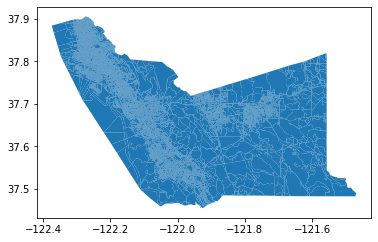

In [48]:
blocks.plot()

Oops, I meant to do that after I actually made sure the 311 data was fully joined in the set.

In [49]:
joined['geoid10'].value_counts()

060014039003003    14
060014044003000     5
060014003001010     4
060014079003007     3
060014046004005     3
                   ..
060014092001008     1
060014038004012     1
060014062011001     1
060014049004015     1
060014002002006     1
Name: geoid10, Length: 398, dtype: int64

So it looks like there is one census block with 14 requests in 2009, I wonder where that is and how many people live there, etc.

In [50]:
counts = joined['geoid10'].value_counts().rename_axis('geoid10').reset_index(name='counts')
print (counts)

             geoid10  counts
0    060014039003003      14
1    060014044003000       5
2    060014003001010       4
3    060014079003007       3
4    060014046004005       3
..               ...     ...
393  060014092001008       1
394  060014038004012       1
395  060014062011001       1
396  060014049004015       1
397  060014002002006       1

[398 rows x 2 columns]


Now that I've got my important columns, I can merge the two datasets based on the geoid.

In [51]:
countsperblock = blocks.merge(counts,on='geoid10')
countsperblock

statefp10 mtfcc10 uace10      name10   intptlat10 blockce10 awater10  \
0          06   G5040         Block 1027  +37.7963903      1027        0   
1          06   G5040         Block 1000  +37.8036170      1000        0   
2          06   G5040         Block 2005  +37.8455877      2005        0   
3          06   G5040         Block 2008  +37.8008155      2008        0   
4          06   G5040         Block 3006  +37.7844635      3006        0   
..        ...     ...    ...         ...          ...       ...      ...   
393        06   G5040         Block 1019  +37.8044133      1019        0   
394        06   G5040         Block 1000  +37.8041112      1000        0   
395        06   G5040         Block 4013  +37.7999683      4013        0   
396        06   G5040         Block 4011  +37.7753540      4011        0   
397        06   G5040         Block 1024  +37.8611524      1024        0   

    funcstat10 aland10          geoid10 tractce10    intptlon10 ur10  \
0            S   11001  060019832001027    983200  -122.2784441        
1            S     950  060014030001000    403000  -122.2693951        
2            S   15180  060014008002005    400800  -122.2865102        
3            S   40287  060014049002008    404900  -122.2210885        
4            S   33315  060014070003006    407000  -122.2023087        
..         ...     ...              ...       ...           ...  ...   
393          S   20400  060014052001019    405200  -122.2419411        
394          S   11800  060014053011000    405301  -122.2500682        
395          S   24311  060014055004013    405500  -122.2461120        
396          S   10553  060014071024011    407102  -122.2118317        
397          S  249433  060014001001024    400100  -122.2376959        

    countyfp10                                           geometry  counts  
0          001  MULTIPOLYGON (((-122.27761 37.79654, -122.2777...       1  
1          001  MULTIPOLYGON (((-122.26884 37.80336, -122.2700...       1  
2          001  MULTIPOLYGON (((-122.28721 37.84493, -122.2872...       1  
3          001  MULTIPOLYGON (((-122.22010 37.80001, -122.2201...       1  
4          001  MULTIPOLYGON (((-122.20160 37.78513, -122.2014...       1  
..         ...                                                ...     ...  
393        001  MULTIPOLYGON (((-122.24087 37.80474, -122.2410...       1  
394        001  MULTIPOLYGON (((-122.25087 37.80416, -122.2507...       1  
395        001  MULTIPOLYGON (((-122.24648 37.80105, -122.2464...       1  
396        001  MULTIPOLYGON (((-122.21283 37.77559, -122.2125...       1  
397        001  MULTIPOLYGON (((-122.24402 37.86074, -122.2439...       2  

[398 rows x 16 columns]

Now I'll sort based by the blocks with the most counts of requests.

In [52]:
countsperblock_sorted = countsperblock.sort_values(by='counts',ascending = False)
countsperblock_sorted

statefp10 mtfcc10 uace10      name10   intptlat10 blockce10 awater10  \
24         06   G5040         Block 3003  +37.8179430      3003        0   
343        06   G5040         Block 3000  +37.8476533      3000        0   
377        06   G5040         Block 1010  +37.8431466      1010        0   
29         06   G5040         Block 1005  +37.7973751      1005        0   
324        06   G5040         Block 4015  +37.8273103      4015        0   
..        ...     ...    ...         ...          ...       ...      ...   
149        06   G5040         Block 3005  +37.7429927      3005        0   
147        06   G5040         Block 2017  +37.7513644      2017        0   
146        06   G5040         Block 3022  +37.8047808      3022        0   
145        06   G5040         Block 1001  +37.7947406      1001        0   
199        06   G5040         Block 1003  +37.8192333      1003        0   

    funcstat10 aland10          geoid10 tractce10    intptlon10 ur10  \
24           S   14773  060014039003003    403900  -122.2522485        
343          S  474840  060014044003000    404400  -122.2079876        
377          S   41260  060014003001010    400300  -122.2489861        
29           S   15490  060019832001005    983200  -122.2736820        
324          S  102849  060014045024015    404502  -122.2085940        
..         ...     ...              ...       ...           ...  ...   
149          S   18047  060014104003005    410400  -122.1640024        
147          S     814  060014095002017    409500  -122.1813667        
146          S     941  060014050003022    405000  -122.2327526        
145          S   68612  060014079001001    407900  -122.1841837        
199          S   27716  060014047001003    404700  -122.2060864        

    countyfp10                                           geometry  counts  
24         001  MULTIPOLYGON (((-122.25136 37.81622, -122.2514...      14  
343        001  MULTIPOLYGON (((-122.20859 37.84672, -122.2083...       5  
377        001  MULTIPOLYGON (((-122.25158 37.84246, -122.2515...       4  
29         001  MULTIPOLYGON (((-122.27262 37.79730, -122.2727...       3  
324        001  MULTIPOLYGON (((-122.20626 37.82440, -122.2066...       3  
..         ...                                                ...     ...  
149        001  MULTIPOLYGON (((-122.16509 37.74235, -122.1651...       1  
147        001  MULTIPOLYGON (((-122.18216 37.75097, -122.1821...       1  
146        001  MULTIPOLYGON (((-122.23231 37.80493, -122.2323...       1  
145        001  MULTIPOLYGON (((-122.18252 37.79338, -122.1828...       1  
199        001  MULTIPOLYGON (((-122.19934 37.81156, -122.1995...       1  

[398 rows x 16 columns]

Most blocks have only one request, so once I put colors on this, I'm sure most of the map will be the same color.

<AxesSubplot:>

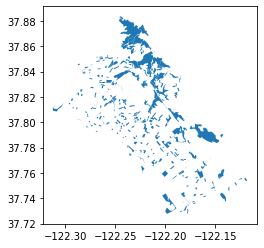

In [53]:
countsperblock.plot()

This is interesting because back in 2009, really not that many census blocks were requesting 311 fixes for the roads. But block groups are such a small area that it doesn't really surprise me.

Now I want to organize by colors and see what things look like.

<AxesSubplot:>

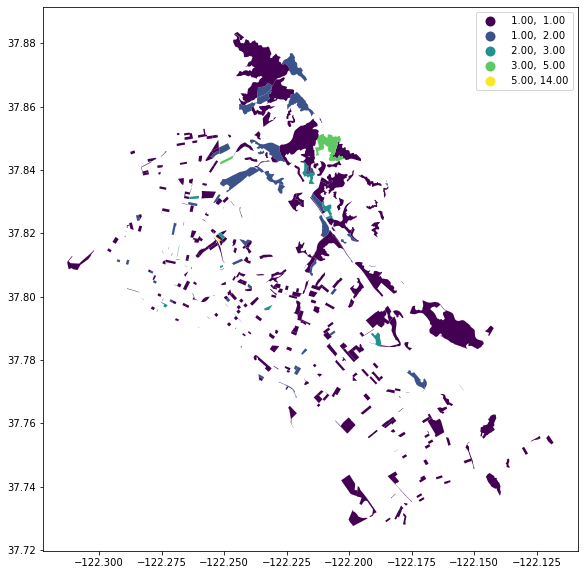

In [54]:
countsperblock.plot(figsize=(10,10),
                 column='counts',
                 legend=True, 
                 scheme='NaturalBreaks')

I'll try the same thing but with different breaks.

/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

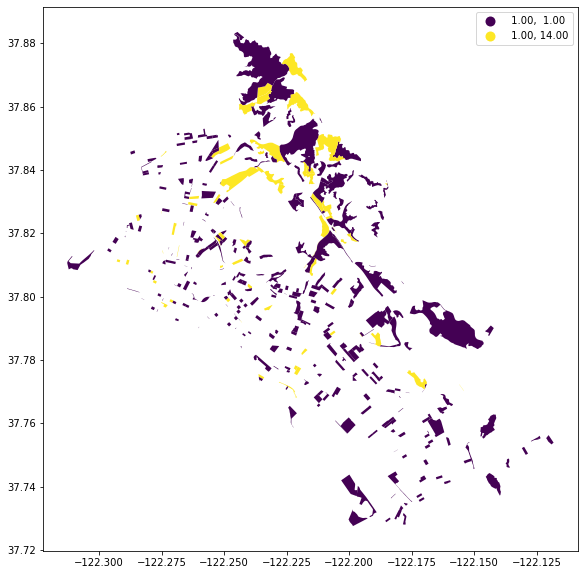

In [55]:
countsperblock.plot(figsize=(10,10),
                 column='counts',
                 legend=True, 
                 scheme='quantiles')

Okay whoops, that doesn't really do much help.

<AxesSubplot:>

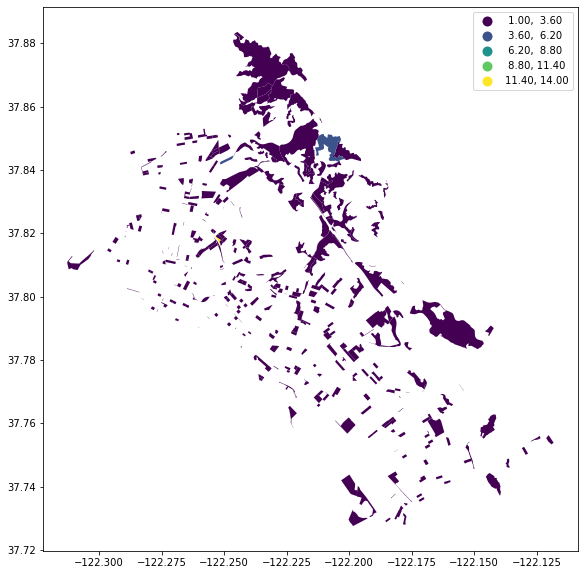

In [56]:
countsperblock.plot(figsize=(10,10),
                 column='counts',
                 legend=True, 
                 scheme='equal_interval')

This one is ok, but they're not integers so I think it makes more sense to keep the data as integers when looking at them on a map.

Now I want to look at this map with the basemap of Oakland underneath it.

In [57]:
countsperblock.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [58]:
gdf_basemap = countsperblock.to_crs(epsg=3857)

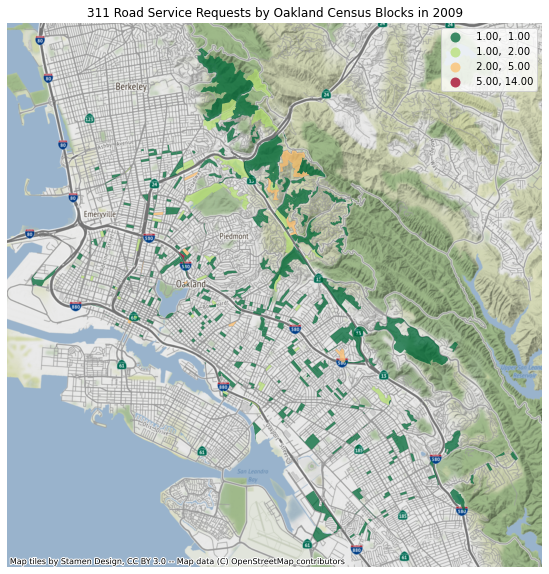

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))


gdf_basemap.plot(column='counts', 
            cmap='RdYlGn_r', 
            scheme='NaturalBreaks',
            k=4, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax,
            legend=True
           )

ax.axis("off")
ax.set_title("311 Road Service Requests by Oakland Census Blocks in 2009")
ctx.add_basemap(ax)

This looks cool, one of my concerns is that in block groups that are bigger, it looks like there are more requests just because more of that area is shaded. I think a better type of view would be a heat map style, but this is fine for now.

I really want to see that one block with 14 requests.

/opt/conda/lib/python3.9/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


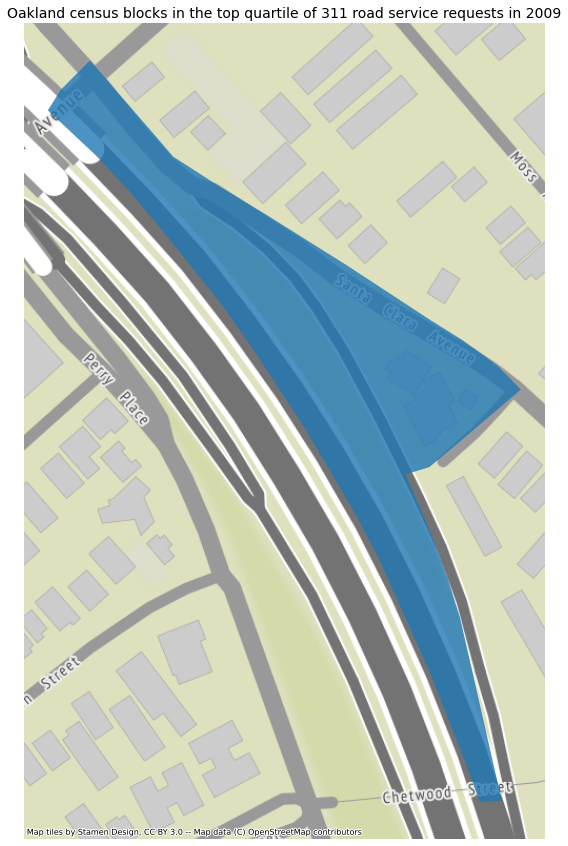

In [60]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf_basemap[gdf_basemap['counts']>13].plot(ax=ax, alpha=0.8)

ax.axis('off')


ax.set_title('Oakland census blocks in the top quartile of 311 road service requests in 2009',fontsize=14)

ctx.add_basemap(ax)

This is interesting because it looks like a highway, so I wonder if the reason this particular area got so many requests is because there were so many people using the highway, and with damage to such a trafficked area, it would get more requests to be fixed.

In [61]:
joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 488 entries, 38 to 525
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   REQUESTID        488 non-null    object  
 1   DATETIMEINIT     488 non-null    object  
 2   SOURCE           488 non-null    object  
 3   DESCRIPTION      488 non-null    object  
 4   REQCATEGORY      488 non-null    object  
 5   LAT              488 non-null    float64 
 6   LONG             488 non-null    float64 
 7   STATUS           488 non-null    object  
 8   DATETIMECLOSED   488 non-null    object  
 9   COUNCILDISTRICT  488 non-null    object  
 10  PROBADDRESS      488 non-null    object  
 11  City             488 non-null    object  
 12  State            488 non-null    object  
 13  TIMETOCLOSE      488 non-null    float64 
 14  geometry         488 non-null    geometry
 15  index_right      488 non-null    int64   
 16  statefp10        488 non-null    ob

Now I want to look at the time to close data, so firstly I want to find out the median for how long it took for 311 requests to be closed in 2009.

In [62]:
timetoclose.median()

51.5

<AxesSubplot:>

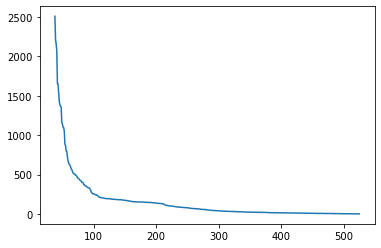

In [63]:
oakland09_closed['TIMETOCLOSE'].plot()

In [64]:
oakland09_closed_grouped = joined.groupby(['geoid10']).median()[['TIMETOCLOSE']]
oakland09_closed_grouped.head(10)

TIMETOCLOSE
geoid10                     
060014001001007        12.00
060014001001015       525.55
060014001001021       173.10
060014001001024       129.00
060014001001027        25.00
060014001001030         7.00
060014001001033        70.90
060014001001039       298.55
060014001001045        17.80
060014001001049       208.90

I'll definitely want to plot this within the geoid blocks so we can see if certain areas took less time to close than others.

In [65]:
oakland09_closed_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 060014001001007 to 060019832001055
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TIMETOCLOSE  398 non-null    float64
dtypes: float64(1)
memory usage: 6.2+ KB


In [66]:
timedf = oakland09_closed_grouped.rename_axis('geoid10').reset_index('geoid10')
print (timedf)

             geoid10  TIMETOCLOSE
0    060014001001007        12.00
1    060014001001015       525.55
2    060014001001021       173.10
3    060014001001024       129.00
4    060014001001027        25.00
..               ...          ...
393  060019820001005       160.20
394  060019820001021         4.80
395  060019832001005        89.30
396  060019832001027        36.10
397  060019832001055        36.10

[398 rows x 2 columns]


In [67]:
timegdf = blocks.merge(timedf,on='geoid10')
timegdf

statefp10 mtfcc10 uace10      name10   intptlat10 blockce10 awater10  \
0          06   G5040         Block 1027  +37.7963903      1027        0   
1          06   G5040         Block 1000  +37.8036170      1000        0   
2          06   G5040         Block 2005  +37.8455877      2005        0   
3          06   G5040         Block 2008  +37.8008155      2008        0   
4          06   G5040         Block 3006  +37.7844635      3006        0   
..        ...     ...    ...         ...          ...       ...      ...   
393        06   G5040         Block 1019  +37.8044133      1019        0   
394        06   G5040         Block 1000  +37.8041112      1000        0   
395        06   G5040         Block 4013  +37.7999683      4013        0   
396        06   G5040         Block 4011  +37.7753540      4011        0   
397        06   G5040         Block 1024  +37.8611524      1024        0   

    funcstat10 aland10          geoid10 tractce10    intptlon10 ur10  \
0            S   11001  060019832001027    983200  -122.2784441        
1            S     950  060014030001000    403000  -122.2693951        
2            S   15180  060014008002005    400800  -122.2865102        
3            S   40287  060014049002008    404900  -122.2210885        
4            S   33315  060014070003006    407000  -122.2023087        
..         ...     ...              ...       ...           ...  ...   
393          S   20400  060014052001019    405200  -122.2419411        
394          S   11800  060014053011000    405301  -122.2500682        
395          S   24311  060014055004013    405500  -122.2461120        
396          S   10553  060014071024011    407102  -122.2118317        
397          S  249433  060014001001024    400100  -122.2376959        

    countyfp10                                           geometry  TIMETOCLOSE  
0          001  MULTIPOLYGON (((-122.27761 37.79654, -122.2777...         36.1  
1          001  MULTIPOLYGON (((-122.26884 37.80336, -122.2700...        141.8  
2          001  MULTIPOLYGON (((-122.28721 37.84493, -122.2872...         21.9  
3          001  MULTIPOLYGON (((-122.22010 37.80001, -122.2201...        192.9  
4          001  MULTIPOLYGON (((-122.20160 37.78513, -122.2014...         30.8  
..         ...                                                ...          ...  
393        001  MULTIPOLYGON (((-122.24087 37.80474, -122.2410...         56.0  
394        001  MULTIPOLYGON (((-122.25087 37.80416, -122.2507...          4.3  
395        001  MULTIPOLYGON (((-122.24648 37.80105, -122.2464...         89.1  
396        001  MULTIPOLYGON (((-122.21283 37.77559, -122.2125...         28.0  
397        001  MULTIPOLYGON (((-122.24402 37.86074, -122.2439...        129.0  

[398 rows x 16 columns]

Now that the data is merged and it's based on time, I can put it over a map of Oakland.

In [68]:
timegdf_basemap = timegdf.to_crs(epsg=3857)

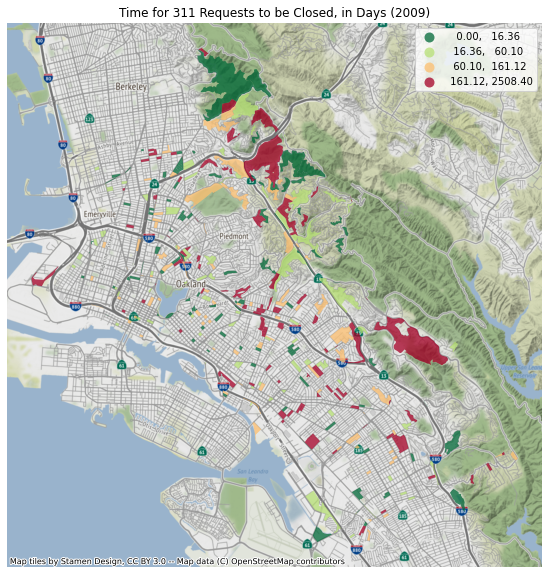

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))

timegdf_basemap.plot(column='TIMETOCLOSE', 
            cmap='RdYlGn_r', 
            scheme='quantiles',
            k=4, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax,
            legend=True
           )

ax.axis("off")
ax.set_title("Time for 311 Requests to be Closed, in Days (2009)")
ctx.add_basemap(ax)

In [70]:
timetoclose.mean()

154.92479508196723

So the average time to close was a lot higher than the median, which makes sense because a couple of requests took years to close.

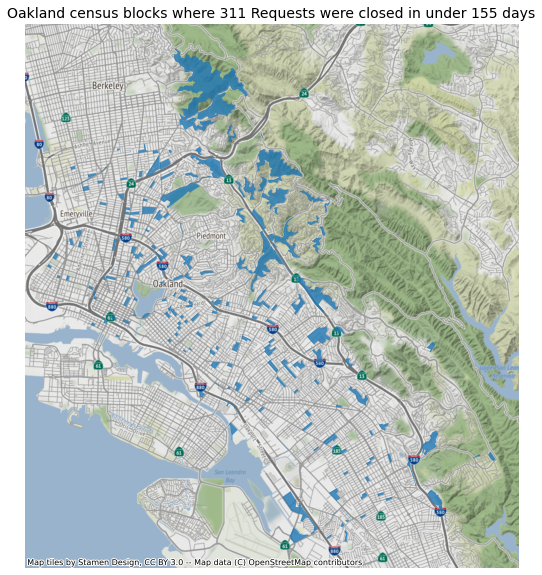

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))

timegdf_basemap[timegdf_basemap['TIMETOCLOSE'] < 155].plot(ax=ax, alpha=0.8)

ax.axis('off')

ax.set_title('Oakland census blocks where 311 Requests were closed in under 155 days',fontsize=14)

ctx.add_basemap(ax)

I'll map the areas that had requests closed in under the average of 155 days.

In [72]:
timetoclose.median()

51.5

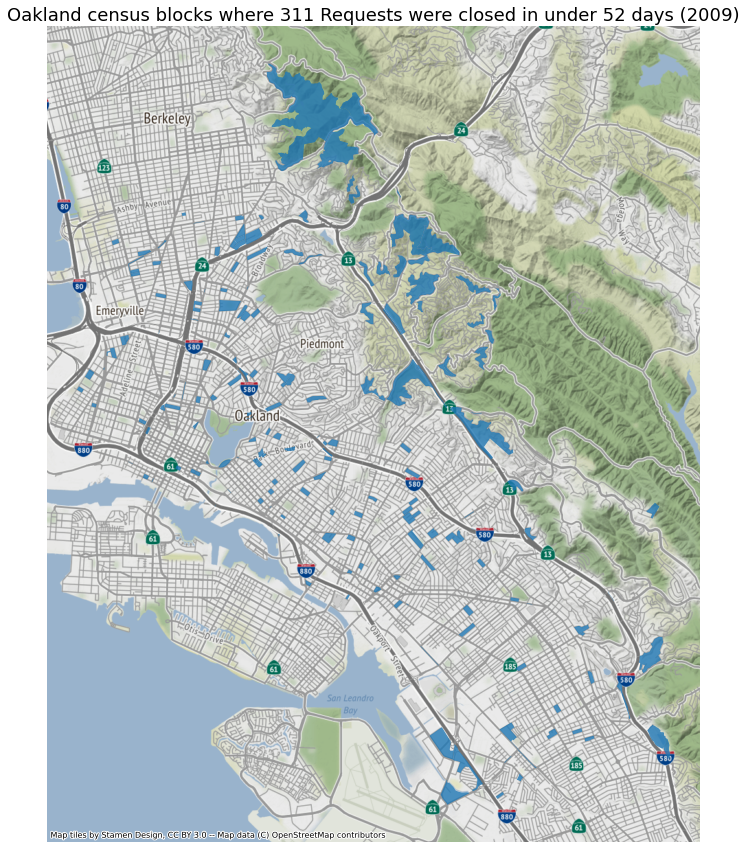

In [73]:
fig, ax = plt.subplots(figsize=(15, 15))

timegdf_basemap[timegdf_basemap['TIMETOCLOSE'] < 52].plot(ax=ax, alpha=0.8)

ax.axis('off')

ax.set_title('Oakland census blocks where 311 Requests were closed in under 52 days (2009)',fontsize=18)

ctx.add_basemap(ax)

This is a map that shows the block groups that contain requests that took less than the median time to be resolved/closed, so that could be interesting. Just from a basic look, it seems like maybe it's kind of random? I know we talked about maybe mapping out where the service centers are located and seeing if that meant certain areas took longer to fix, but I think that might be for another day.

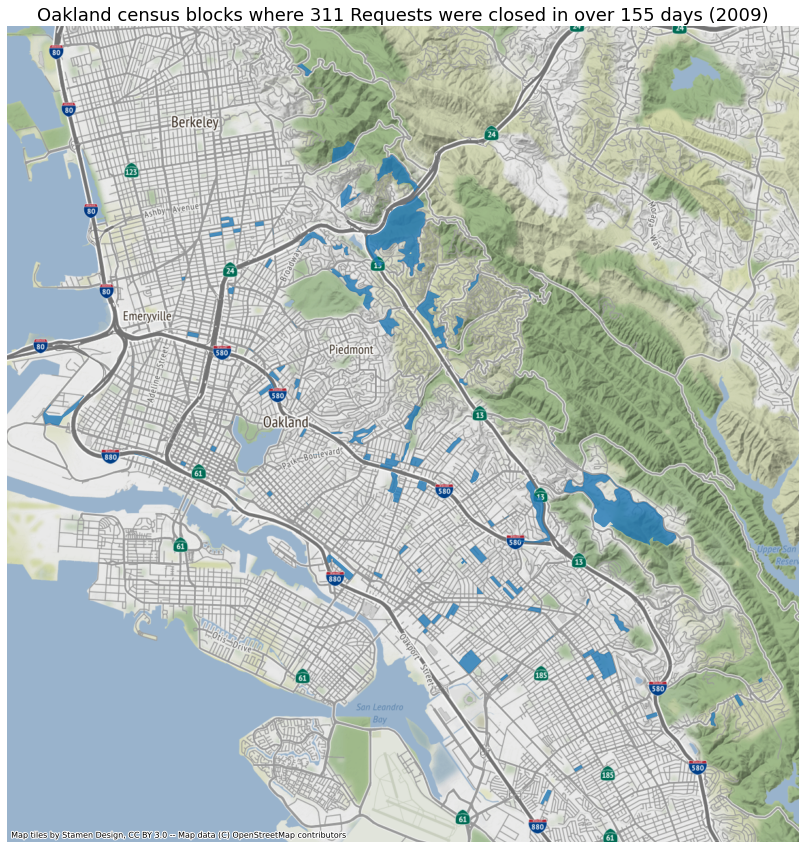

In [74]:
fig, ax = plt.subplots(figsize=(15, 15))

timegdf_basemap[timegdf_basemap['TIMETOCLOSE'] > 155].plot(ax=ax, alpha=0.8)

ax.axis('off')

ax.set_title('Oakland census blocks where 311 Requests were closed in over 155 days (2009)',fontsize=18)

ctx.add_basemap(ax)

In [45]:
oakland09_closed.to_file("Closed2009.geojson", driver='GeoJSON')

In [ ]:
timegdf.to_file("Time to Close.geojson")

This notebook and the Kepler map file was completed by Mary Alice (all 2009 data was processed by me)